In [1]:
import numpy as np
import pandas as pd
from interactions_data import create_index, reset_ids
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil

In [2]:
try:
    shutil.rmtree('./ml-20m')
    print('ml-20M directory already exists, removing it first')
except:
    print('no existing directory found, all good')

# stable link for dataset
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-20m.zip'

# download zip file from link
print('downloading and saving dataset from movielens stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)

print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')
    
# remove zip file from directory
print('deleting zip file')
os.remove('ml-20m.zip')

ml-20M directory already exists, removing it first
downloading and saving dataset from movielens stable link...
unzipping contents
deleting zip file


In [3]:
path = 'ml-20m/'

In [4]:
df = pd.read_csv(path+'ratings.csv').drop('timestamp', axis=1)

In [5]:
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [6]:
df.shape

(20000263, 3)

In [7]:
movies = pd.read_csv(path+'movies.csv')
genome_tags = pd.read_csv(path+'genome-tags.csv')
genome_scores = pd.read_csv(path+'genome-scores.csv')

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies.shape

(27278, 3)

In [10]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [11]:
genome_scores.shape

(11709768, 3)

In [12]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [13]:
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

In [14]:
# length before
print(len(movies), len(genome_scores), len(genome_tags))

# keep metadata only for movies that have receieved ratings
movies = movies[movies['movieId'].isin(movie_ids)]
genome_scores = genome_scores[genome_scores['movieId'].isin(movie_ids)]
tag_ids = genome_scores['tagId'].unique()
genome_tags = genome_tags[genome_tags['tagId'].isin(tag_ids)]

# length after
print(len(movies), len(genome_scores), len(genome_tags))

27278 11709768 1128
26744 11697360 1128


In [15]:
# create ID encoders
user_encoder, _ = create_index(user_ids)
movie_encoder, _ = create_index(movie_ids)

### Encode IDs from 0-n

In [16]:
# replace all IDs with sequential 0-N IDs
df['userId'] = df['userId'].apply(lambda x: user_encoder[x])
df['movieId'] = df['movieId'].apply(lambda x: movie_encoder[x])

genome_scores['movieId'] = genome_scores['movieId'].apply(lambda x: movie_encoder[x])

movies['movieId'] = movies['movieId'].apply(lambda x: movie_encoder[x])

In [17]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = df.rating.max()
min_score = df.rating.min()

In [18]:
print(n_users, df.userId.max())
print(n_items, df.movieId.max())
print(min_score, max_score)

138493 138492
26744 26743
0.5 5.0


In [19]:
df.head()

,userId,movieId,rating
0,0,0,3.5
1,0,1,3.5
2,0,2,3.5
3,0,3,3.5
4,0,4,3.5


In [20]:
movies[movies['movieId'].isin(df.movieId.head())]

,movieId,title,genres
1,0,Jumanji (1995),Adventure|Children|Fantasy
28,1,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
31,2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
46,3,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
49,4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Save file in chunks

In [21]:
number_of_chunks = 8
[df_i.to_csv(path+f'ratings{i+1}.csv') for i, df_i in enumerate(np.array_split(df, number_of_chunks))]

[None, None, None, None, None, None, None, None]

In [22]:
df.movieId.nunique()

26744

In [23]:
movies.movieId.nunique()

26744

In [24]:
movies.head()

,movieId,title,genres
0,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,Jumanji (1995),Adventure|Children|Fantasy
2,175,Grumpier Old Men (1995),Comedy|Romance
3,1994,Waiting to Exhale (1995),Comedy|Drama|Romance
4,1044,Father of the Bride Part II (1995),Comedy


In [25]:
genres = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller',
          'War','Western']

In [26]:
for g in genres:
    movies[g] = movies['genres'].apply(lambda x: int(g in x))

In [27]:
movies = movies.drop('genres', axis=1)

In [28]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,227,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,175,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1994,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1044,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
movies.sort_values('movieId').to_csv(path+'movies.csv', index=False)
# tags.to_csv(path+'tags.csv', index=False)

### remove all other files

In [30]:
dir_name = "./ml-20m/"
folder = os.listdir(dir_name)

files_to_delete = ['genome-tags.csv', 'genome-scores.csv', 'links.csv', 'ratings.csv', 'tags.csv']

for item in folder:
    if item in files_to_delete:
        os.remove(os.path.join(dir_name, item))

## EDA

In [35]:
from glob import glob
ratings = [f'ratings{i}.csv' for i in range(1,9)]

In [36]:
# load all of train and test data as one dataframe
df = pd.concat((pd.read_csv(path+file) for file in ratings), ignore_index=True)
movies = pd.read_csv(path+'movies.csv')

# create one merged DataFrame
df = pd.merge(movies, df)[['userId','movieId','rating','title']]

In [37]:
df.shape

(20000263, 4)

In [38]:
df.head()

,userId,movieId,rating,title
0,0,0,3.5,Jumanji (1995)
1,4,0,3.0,Jumanji (1995)
2,12,0,3.0,Jumanji (1995)
3,28,0,3.0,Jumanji (1995)
4,33,0,3.0,Jumanji (1995)


In [39]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

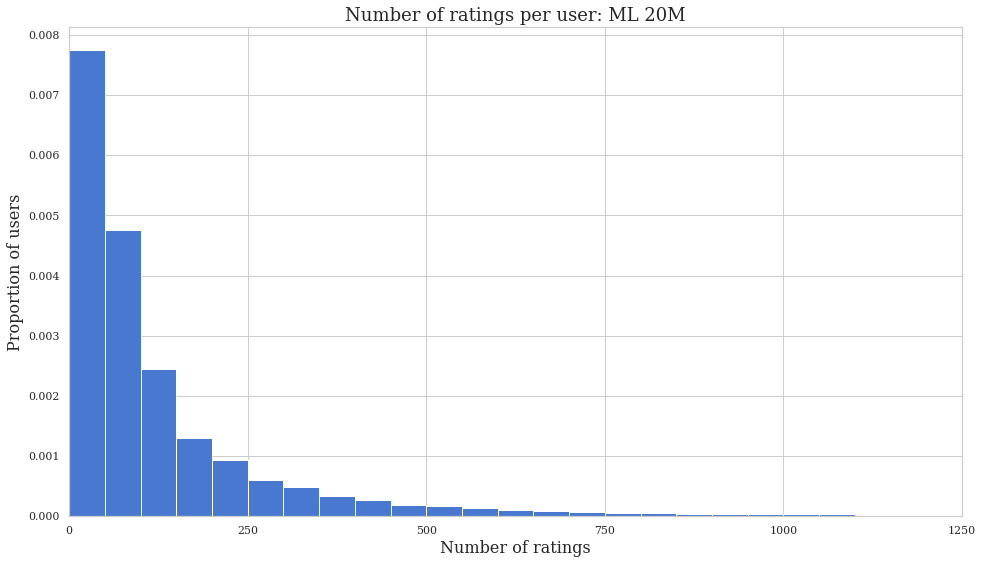

Min ratings by single user: 20
Max ratings by single user: 9254
Avg number of ratings per user: 144


In [40]:
user_counts = df['userId'].value_counts()

plt.hist(user_counts, bins=np.arange(0,1201,50), density=True)
plt.title('Number of ratings per user: ML 20M', fontsize=18)
plt.xlabel('Number of ratings', fontsize=16)
plt.ylabel('Proportion of users', fontsize=16)
plt.xlim(0, 1250)
plt.xticks(np.arange(0,1251,250))
plt.savefig('../figures/ml_20m_user-ratings.pdf', bbox_inches='tight')
plt.show()

# user with fewest ratings
print('Min ratings by single user:',
      user_counts.min())

# user with most ratings
print('Max ratings by single user:',
      user_counts.max())

# average number of ratings per user
print('Avg number of ratings per user:',
      round(user_counts.mean()))

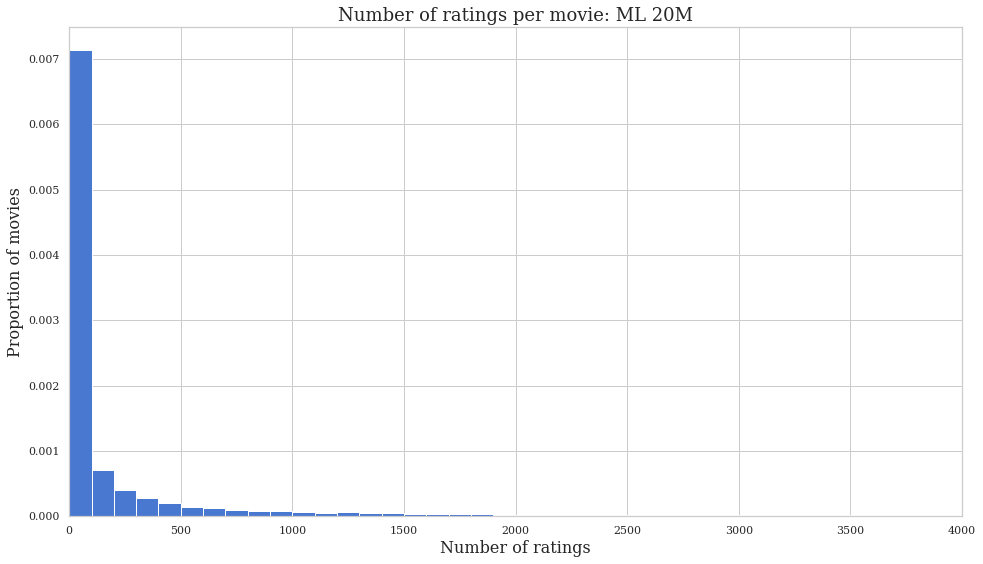

Min ratings of single movie: 1
Max ratings of single movie: 67310
Avg number of ratings per movie: 748


In [41]:
movie_counts = df['title'].value_counts()

plt.hist(movie_counts, bins=np.arange(0,4001,100), density=True)
plt.title('Number of ratings per movie: ML 20M', fontsize=18)
plt.xlabel('Number of ratings', fontsize=16)
plt.ylabel('Proportion of movies', fontsize=16)
plt.xlim(0, 4000)
plt.xticks(np.arange(0,4001,500))
plt.savefig('../figures/ml_20m_movie-ratings.pdf', bbox_inches='tight')
plt.show()

# movie with fewest ratings
print('Min ratings of single movie:',
      movie_counts.min())

# movie with most ratings
print('Max ratings of single movie:',
      movie_counts.max())

# average number of ratings per book
print('Avg number of ratings per movie:',
      round(movie_counts.mean()))

In [42]:
movie_counts.head()

Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: title, dtype: int64

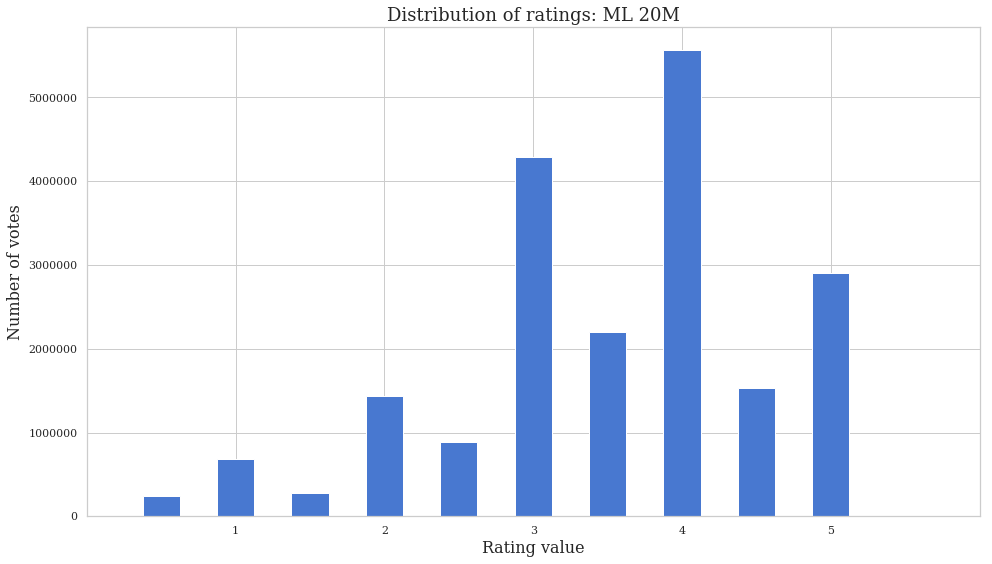

Avg rating: 3.53


In [43]:
plt.hist(df['rating'].values, bins=np.arange(.375, 5.126, .25))
plt.xlim(0,6)
plt.xticks(np.arange(1,5.1,1))
plt.title('Distribution of ratings: ML 20M', fontsize=18)
plt.xlabel('Rating value', fontsize=16)
plt.ylabel('Number of votes', fontsize=16)
plt.savefig('../figures/ml_20m_ratings-dist.pdf', bbox_inches='tight')
plt.show()

print('Avg rating:', round(df['rating'].mean(),2))

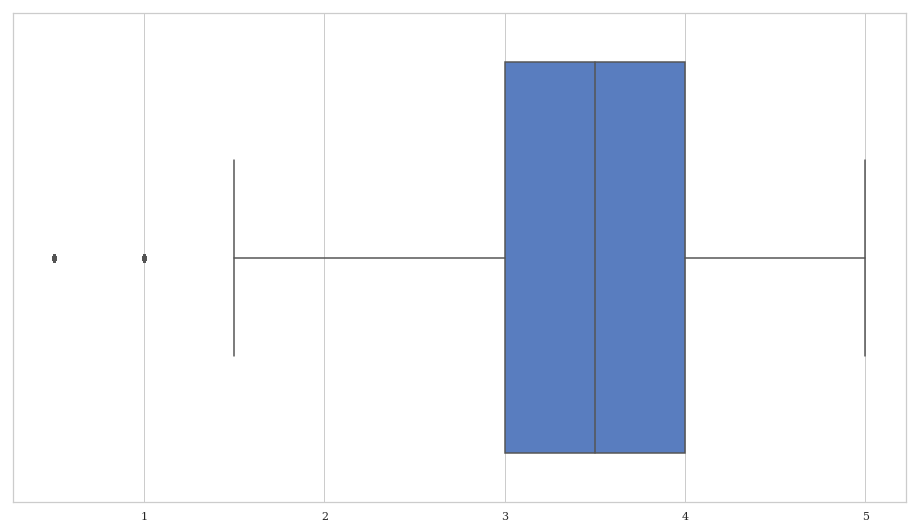

['Q2', 'Q3', 'Q5']
[3.  3.5 4. ]


In [44]:
sns.boxplot(df['rating'].values)
plt.show()

print((['Q2','Q3','Q5']))
print(np.percentile(df.rating.values, [25,50,75]))

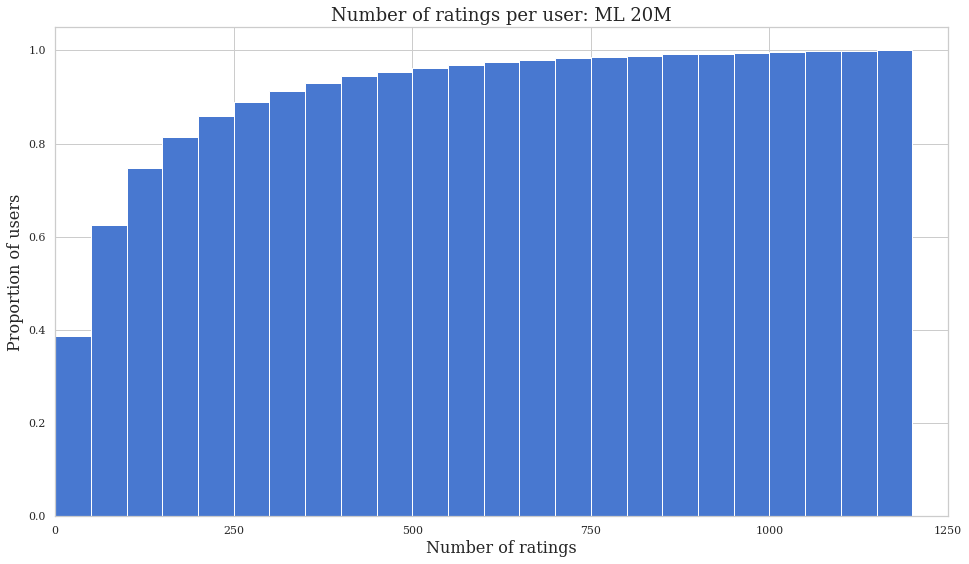

In [45]:
plt.hist(user_counts, bins=np.arange(0,1201,50), density=True, cumulative=True)
plt.title('Number of ratings per user: ML 20M', fontsize=18)
plt.xlabel('Number of ratings', fontsize=16)
plt.ylabel('Proportion of users', fontsize=16)
plt.xlim(0, 1250)
plt.xticks(np.arange(0,1251,250))
plt.show()

In [46]:
movies.mean()

movieId        13371.500000
Action             0.129599
Adventure          0.085515
Animation          0.037952
Children           0.041804
Comedy             0.307807
Crime              0.108024
Documentary        0.089403
Drama              0.488409
Fantasy            0.052273
Film-Noir          0.012040
Horror             0.096844
Musical            0.037990
Mystery            0.055676
Romance            0.150651
Sci-Fi             0.064313
Thriller           0.154390
War                0.043860
Western            0.024529
dtype: float64